##HIT Server Elec

This notebook will extract typical profiles for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [3]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [4]:
# os.chdir(workingdir)

In [5]:
df = pd.read_csv(workingdir+"aggset2_QW/HIT_QW.csv", index_col="Date Time", parse_dates=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50144 entries, 2008-04-21 17:00:00 to 2014-01-10 00:00:00
Data columns (total 28 columns):
HITMEL01QW_A [kWh]    46644 non-null float64
HITMEL11QW_A [kWh]    44364 non-null float64
HITMEL12QW_A [kWh]    44364 non-null float64
HITMEL30QW_A [kWh]    47550 non-null float64
HITMEL50QW_A [kWh]    47354 non-null float64
HITMEL60QW_A [kWh]    47354 non-null float64
HITMEL65QW_A [kWh]    47354 non-null float64
HITMEL70QW_A [kWh]    47550 non-null float64
HITMEL71QW_A [kWh]    47354 non-null float64
HITMEL72QW_A [kWh]    47544 non-null float64
HITMEL73QW_A [kWh]    47544 non-null float64
HITMEL74QW_A [kWh]    47550 non-null float64
HITMEL75QW_A [kWh]    44364 non-null float64
HITMEL76QW_A [kWh]    47543 non-null float64
HITMEL77QW_A [kWh]    47291 non-null float64
HITMEL80QW_A [kWh]    46644 non-null float64
HITMHE01QW_A [kWh]    50067 non-null float64
HITMHE10QW_A [kWh]    50067 non-null float64
HITMHE11QW_A [kWh]    45020 non-null float64
H

In [7]:
point = "HITMEL74QW_A [kWh]"

In [8]:
df_QW = pd.DataFrame(df[point].truncate(before='2013',after='2014'))

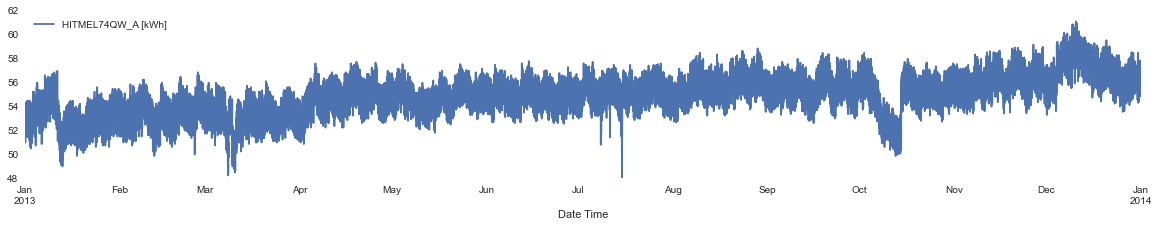

In [9]:
df_QW.plot(figsize=(20,3));

##Convert to SAX

In [10]:
df = df_QW.dropna()

In [11]:
#df.head()

In [12]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [13]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [14]:
a = 3
w = '4h'

In [15]:
from scipy.stats import norm
import numpy as np
import string

In [16]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [17]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

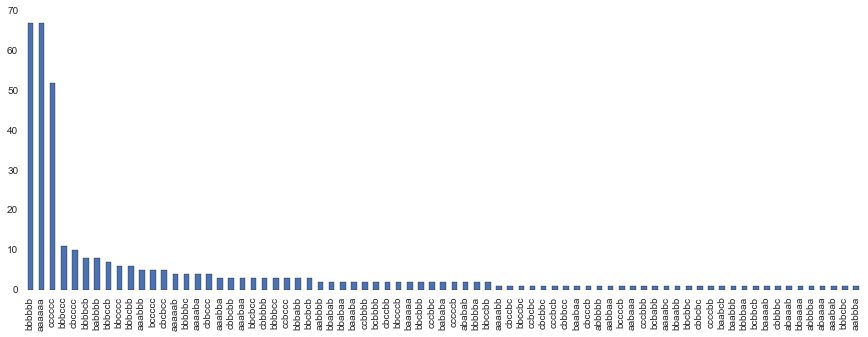

In [18]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [19]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

bbbbbb    67
aaaaaa    67
cccccc    52
bbbccc    11
cbcccc    10
bbbbcb     8
babbbb     8
dtype: int64

In [20]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

bbbccb    7
bbcccc    6
bbbcbb    6
aaabbb    5
bccccc    5
dtype: int64

In [21]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [22]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [23]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [24]:
df = motifdata.drop(['SAXstring'], axis=1)

In [25]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,51.125,53.125,54.375,53.000,51.000,54.250,51.625,54.250,51.500,54.250,...,54.125,53.000,51.500,52.500,53.000,54.000,51.500,54.50,51.500,54.500
2013-01-02,51.625,54.125,51.500,54.250,51.625,52.875,52.250,54.375,51.375,52.875,...,54.500,52.750,51.875,52.500,53.625,50.625,52.000,53.75,51.125,53.875
2013-01-03,50.500,53.875,52.375,52.500,50.875,51.750,53.875,52.625,52.500,51.000,...,52.250,52.875,55.250,53.875,52.625,53.375,55.000,51.75,55.250,53.500
2013-01-04,52.000,53.250,55.000,52.250,53.500,54.500,53.375,52.000,54.875,51.500,...,53.750,52.375,51.000,54.250,52.500,52.375,55.625,53.00,54.500,56.000
2013-01-05,54.125,52.875,56.000,54.375,54.000,54.000,52.500,55.375,52.375,55.250,...,53.750,55.375,52.375,53.875,55.375,51.750,55.250,52.50,55.250,53.875


In [26]:
df = df_pivot

In [27]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [28]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [29]:
df.head()

,HITMEL74QW_A [kWh]
timestampstring,
2013-01-01 00:00:00,51.125
2013-01-01 01:00:00,53.125
2013-01-01 02:00:00,54.375
2013-01-01 03:00:00,53.000
2013-01-01 04:00:00,51.000


In [30]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [31]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [32]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [33]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [34]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [35]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [36]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [37]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

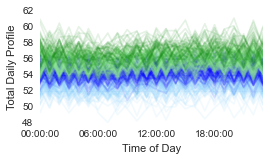

In [38]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("server_clusters_total_overlaid_profiles.pdf")

In [39]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [40]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

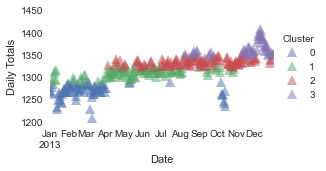

In [41]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("server_clusters_overtime.pdf")

In [42]:
dailyclusters.head()

ClusterNo2          0                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-06 2013-01-12   
00:00:00       51.125     51.625     50.500      52.00     52.500     51.375   
01:00:00       53.125     54.125     53.875      53.25     53.625     54.125   
02:00:00       54.375     51.500     52.375      55.00     55.000     51.250   
03:00:00       53.000     54.250     52.500      52.25     52.500     53.875   
04:00:00       51.000     51.625     50.875      53.50     54.125     51.250   

ClusterNo2                                                ...              3  \
Date       2013-01-13 2013-01-14 2013-01-15 2013-01-16    ...     2013-12-18   
00:00:00       52.125     53.375     54.000     54.250    ...        56.8125   
01:00:00       49.875     50.625     51.500     51.375    ...        57.5000   
02:00:00       52.625     53.250     54.125     54.125    ...        55.0000   
03:00:00       49.750     50.500     51.125     52.750    ...        56.8125   
04:00:00       52.750     51.875     53.125     50.750    ...        57.8750   

ClusterNo2                                                                    \
Date       2013-12-19 2013-12-20 2013-12-21 2013-12-22 2013-12-23 2013-12-24   
00:00:00      58.3750    56.8125    58.8750    56.2500    57.7500    57.1875   
01:00:00      54.4375    58.2500    57.5625    57.8750    54.5000    55.1875   
02:00:00      58.5000    56.8750    55.8125    55.1250    58.1875    56.0000   
03:00:00      55.0625    55.9375    58.9375    56.8750    54.4375    58.3125   
04:00:00      57.0625    58.0000    57.0625    58.1875    56.6250    55.1875   

ClusterNo2                                   
Date       2013-12-28 2013-12-29 2013-12-31  
00:00:00      58.0000    55.3125    57.8750  
01:00:00      54.5000    56.1250    54.6250  
02:00:00      57.1875    56.9375    58.5000  
03:00:00      55.8125    58.3125    55.1875  
04:00:00      56.6250    56.0000    57.1875  

[5 rows x 364 columns]

In [43]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,1268.625,NaN,NaN,NaN
2013-01-02,1264.625,NaN,NaN,NaN
2013-01-03,1270.750,NaN,NaN,NaN
2013-01-04,1278.750,NaN,NaN,NaN
2013-01-05,NaN,1293.75,NaN,NaN


In [44]:
calendar.to_csv("server_calendar.csv")

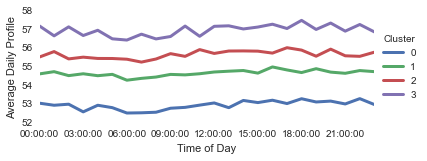

In [45]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("server_clusters_averagedprofiles.pdf")

In [46]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

61.124999994644902

In [47]:
#dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / (dfclusterunstackedpivoted.groupby('Time').max().max().max()*0.7)

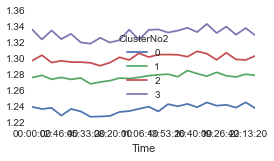

In [48]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.plot()

In [49]:
normalizedprofiles.to_csv("server_Schedules.csv")

In [50]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

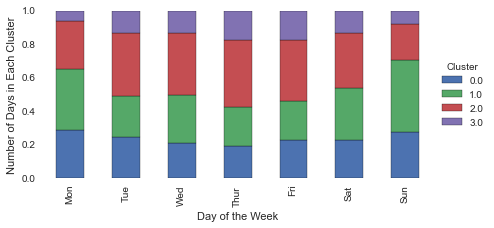

In [51]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("server_clusters_dailybreakdown.pdf")

In [52]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.288462,0.365385,0.288462,0.057692
Tue,0.245283,0.245283,0.377358,0.132075
Wed,0.211538,0.288462,0.365385,0.134615
Thur,0.192308,0.230769,0.403846,0.173077
Fri,0.230769,0.230769,0.365385,0.173077
Sat,0.230769,0.307692,0.326923,0.134615
Sun,0.274510,0.431373,0.215686,0.078431


##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [98]:
normalizedprofilesizedprofiles = pd.read_csv("Schedules.csv", index_col='Time')

In [99]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.638711,0.645010,0.649630,0.681483
01:00:00,0.638192,0.642890,0.646534,0.674539
02:00:00,0.636875,0.643543,0.645633,0.675610
03:00:00,0.637267,0.644538,0.646009,0.677475
04:00:00,0.637855,0.643748,0.645649,0.674889


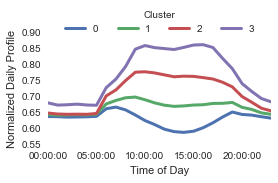

In [100]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [60]:
calendar = pd.read_csv("calendar.csv", index_col='timestampstring', parse_dates=True)

In [61]:
#calendar.fillna(0).dropna(how="all").info()

In [62]:
import time

In [63]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [64]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356994800,NaN,2104.05800,NaN,NaN,1356994800
1357081200,NaN,2086.20650,NaN,NaN,1357081200
1357167600,NaN,NaN,2232.2355,NaN,1357167600
1357254000,NaN,NaN,2271.1950,NaN,1357254000
1357340400,NaN,2167.48975,NaN,NaN,1357340400


In [65]:
calendar = calendar.drop(['epochtime'], axis=1)

In [66]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356994800,NaN,2104.05800,NaN,NaN
1357081200,NaN,2086.20650,NaN,NaN
1357167600,NaN,NaN,2232.2355,NaN
1357254000,NaN,NaN,2271.1950,NaN
1357340400,NaN,2167.48975,NaN,NaN


In [67]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [68]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1357945200,2080.02375
1,0,1362265200,2103.75700
2,0,1362783600,2068.31450
3,0,1362870000,2026.01475
4,0,1363388400,2079.87450


In [69]:
cal_heatmap.index = cal_heatmap.epochtime

In [70]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1357945200,0,1357945200,2080.02375
1362265200,0,1362265200,2103.75700
1362783600,0,1362783600,2068.31450
1362870000,0,1362870000,2026.01475
1363388400,0,1363388400,2079.87450


In [71]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [72]:
cal_heatmap = cal_heatmap.sort()

In [73]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [74]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [75]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,1
1357081200,1
1357167600,2
1357254000,2
1357340400,1


In [76]:
cal_heatmap = cal_heatmap+1

In [77]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,2
1357081200,2
1357167600,3
1357254000,3
1357340400,2


In [78]:
cal_heatmap.level_0.to_json("hit_cal_heatmap.json")

In [79]:
x = sns.color_palette()

In [80]:
import matplotlib.colors as colors

In [81]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
